In [2]:
# General libraries
import numpy as np # numpy for...
import pandas as pd # pandas for...
import csv
import matplotlib.pyplot as plt

# Perceptron
from sklearn.linear_model import Perceptron

# KNN
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# NN
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import Adam
import tensorflow as tf
from tensorflow import keras

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# Data load
dat_train = pd.read_csv('train.csv', sep=',')
dat_test = pd.read_csv('test.csv', sep=',')
dat_path = np.load('path.npy')
dat_feat = np.load('feat.npy')

In [4]:
# Preprocessing for shape corrections

min = 0
max = 0
minCoeffs = 13
maxCoeffs = 0
minFrames = 100
maxFrames = 0

for i in dat_feat:
    frameCount = 0
    for j in i:
        coffCount = 0
        for k in j:
            if(k<min):
                min = k
            if(k>max):
                max = k
            coffCount += 1
        if(coffCount>maxCoeffs):
            maxCoeffs = coffCount
        if(coffCount<minCoeffs):
            minCoeffs = coffCount
            
        frameCount += 1
    if(frameCount>maxFrames) and (frameCount<1750):
        maxFrames = frameCount
    if(frameCount<minFrames):
        minFrames = frameCount

print(min) # -129.5504
print(max) # 110.54331
print(minCoeffs) # 13
print(maxCoeffs) # 13
print(minFrames) # 20
print(maxFrames) # 1999 is an outlier. let's consider the max as 99

-129.5504
110.54331
13
13
20
99


In [5]:
# Creating dictionary for easier pointers
dat_dc = dict()
for i in dat_path:
    dat_dc[i] = ""
    
for idx,i in enumerate(dat_feat):
    dat_dc[dat_path[idx]] = i

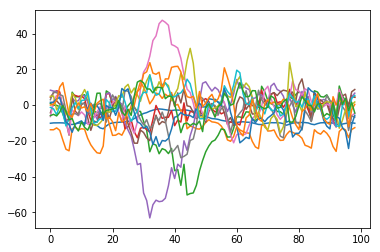

In [6]:
# Features vs time for word "one"
plt.plot(dat_dc["8d37d10e7f97ddea2eca9d39a4cf821b4457b041.wav"])

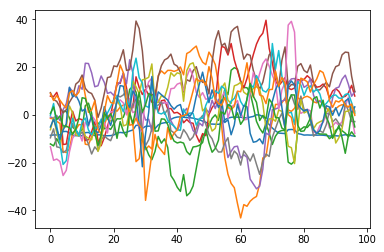

In [7]:
# Features vs time for word "house"
plt.plot(dat_dc["9f1b6b81edb78aac62926fee56d16d947f99c49a.wav"])

### Outliers

We want to check if there are files that have a much bigger lenght than the rest.
For that we started by analyzing a boxplot with all the lenghts:

In [8]:
# List containing the lenghts of all files
data_len=[]
for file in dat_dc:
    data_len.append(len(dat_dc[file]))

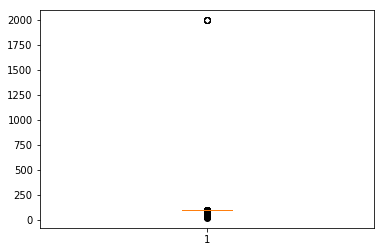

In [9]:
# Boxplot to check how the file lenghts are distributed
plt.boxplot(data_len)
for file in dat_dc:
    data_len.append(len(dat_dc[file]))

plt.show()

# Most of files have a lenght <250 and a few outliers are > 1750

In [10]:
# Identification of the outlier files
outliers=[]
for file in dat_dc:
    if len(dat_dc[file])>1750:
        outliers.append(file)
outliers

['6668691724e0f72761f8848d28ef7ce3110284f6.wav',
 '7e55db5e0474390e7d756f04a2593865f29fa203.wav',
 '0d2440471f9e3118b3e53a22579f4605f3e1ccd2.wav',
 '66fa1eb1049022b855beaae2cd236cdeca4496fd.wav',
 '50f2b7fef58a88cec7fef91f308a04f900156e92.wav',
 '02e3d900a8df6c8ecf5876c1157898393957e35d.wav']

In [11]:
# Check if the outliers are in the test set or in the train set
for i in dat_test.path:
    if i in outliers:
        print(i)
# is not in any of the test files 

for i in dat_train.path:
    if i in outliers:
        print(i)
# is not in any of the train files 

In [12]:
len(dat_train)+len(dat_test)
len(dat_train)+len(dat_test)-len(dat_path)

-6

---------

In [26]:
# Set up zero-fied sets

zero = np.zeros([maxFrames, maxCoeffs])

train = []
for i in dat_train["path"]:
    train.append(dat_dc[i])

test = []
for i in dat_test["path"]:
    test.append(dat_dc[i])

X_train = []
for i in range(len(train)):
    zero[:train[i].shape[0], :train[i].shape[1]] = train[i]
    X_train.append(zero)
    zero = np.zeros([maxFrames, maxCoeffs])
    
X_test = []
for i in range(len(test)):
    zero[:test[i].shape[0], :test[i].shape[1]] = test[i]
    X_test.append(zero)
    zero = np.zeros([maxFrames, maxCoeffs])   

In [ ]:
print('Shape of zeros:',np.shape(zero))
print("Shape of X_train:",np.shape(X_train))
print("Shape of X_test:",np.shape(X_test))

In [27]:
# Setting up the basic functionalities
def features(signal, functions):
    return np.concatenate([ function(signal, axis=1) for function in functions ], axis=1)

summaries = [np.mean, np.min, np.max, np.std]

In [28]:
# Feature-ifying by summaries
X_train_feat = features(X_train, summaries) 
X_test_feat = features(X_test, summaries)

In [29]:
print("Shape of X_train:",np.shape(X_train_feat))
print("Shape of X_test:",np.shape(X_test_feat))

Shape of X_train: (94824, 52)
Shape of X_test: (11005, 52)


In [30]:
# The target values for the trainings are always the same - the words
Y_train = dat_train["word"].values.tolist()
Y_labels = np.unique(Y_train)
print(Y_labels)

['backward' 'bed' 'bird' 'cat' 'dog' 'down' 'eight' 'five' 'follow'
 'forward' 'four' 'go' 'happy' 'house' 'learn' 'left' 'marvin' 'nine' 'no'
 'off' 'on' 'one' 'right' 'seven' 'sheila' 'six' 'stop' 'three' 'tree'
 'two' 'up' 'visual' 'wow' 'yes' 'zero']


# Creating Models

During model creation we use only the X_train_feat dataset (splitting it further)



## Method 0 - Perceptron


In [31]:
X_train_mean = []
for i in dat_train["path"]:
    X_train_mean.append(np.mean(dat_dc[i], axis=0))

In [21]:
y_train = dat_train["word"].values.tolist()
Y_train = dat_train["word"].values.tolist()

In [22]:
train_signal_mean, valid_signal_mean, y_train, y_val = train_test_split(X_train_mean, Y_train, test_size=0.2, random_state=1)

model = Perceptron(random_state=666, max_iter=20) 
model.fit(train_signal_mean, y_train)
y_pred =  model.predict(valid_signal_mean)

acc = accuracy_score(y_val,y_pred)
acc

0.10540469285525969



## Method 1 - KNN

This is our last(better) version of KNN

In [32]:
# Separate the X_train_feat data to training and validation and using the Y_train
train_signal_m1, valid_signal_m1, y_train_m1, y_valid_m1 = train_test_split(X_train, Y_train, test_size=0.2, random_state=1)

In [ ]:
#### WARNING: this runs for a few minutes

# Setting up the KNN
knn = KNeighborsClassifier(n_neighbors=1, metric='minkowski')

# Using the feauturized version of the training/validation data
X_train_feat_m1 = features(train_signal_m1, summaries)
X_valid_feat_m1 = features(valid_signal_m1, summaries)

# Scaling it
scaler = StandardScaler()
X_train_feat_m1 = scaler.fit_transform(X_train_feat_m1)
X_valid_feat_m1 = scaler.transform(X_valid_feat_m1)

# Fitting and predicting
knn.fit(X_train_feat_m1,y_train_m1)
y_pred_m1 = knn.predict(X_valid_feat_m1)

# Getting accuracy score
acc = accuracy_score(y_valid_m1, y_pred_m1)

print(acc)

# n=2 --> All 0.13540732929079885
# n=1 --> All 0.16778275771157394
# n = 1 changed axes --> All 0.513630371737411

In [ ]:
# using it for prediction on test data:
X_test_m1 = scaler.transform(X_test_feat)
pred_test_m1 = knn.predict(X_test_m1)

In [ ]:
print(pred_test_m1)

In [ ]:
# Esport to csv
toprint = dat_test.copy()
toprint['word'] = pred_test_m1
toprint.to_csv('result_m1.csv',index=False)

### Previous tries of KNN 

##### Compressing time - Mean

We start by averaging each feature per time frame so we end up with a vector containing 13 values per file.

In [33]:
# Vector with all the labels of the training set 
Y_train = dat_train["word"].values.tolist()

# Vector containing a list per train file with the average of each feature by time
X_train_mean = []
for i in dat_train["path"]:
    X_train_mean.append(np.mean(dat_dc[i], axis=0))
    
X_train_mean, X_val_mean, y_train, y_val = train_test_split(X_train_mean, Y_train, test_size=0.2, random_state=1)

knn = KNeighborsClassifier(n_neighbors=2, p=2, metric='minkowski')
knn.fit(X_train_mean, y_train)
y_pred = knn.predict(X_val_mean)

acc = accuracy_score(y_val, y_pred)
print("Accuracy is ", round(acc, 3))

Accuracy is  0.326


#####  Distance metrics: Euclidean

In [34]:
#Euclidean it doesn't seem to improve
knn = KNeighborsClassifier(n_neighbors=2, p=2, metric='euclidean')
knn.fit(X_train_mean, y_train)
y_pred = knn.predict(X_val_mean)

acc = accuracy_score(y_val, y_pred)
print("Accuracy is ", round(acc, 3))

Accuracy is  0.326


##### Compressing time - STD

In [35]:
# Vector containing a list per train file with the standard deviation of each feature by time
X_train_std = []
for i in dat_train["path"]:
    X_train_std.append(np.std(dat_dc[i], axis=0))

X_train_std, X_val_std, y_train, y_val = train_test_split(X_train_std, Y_train, test_size=0.2, random_state=1)

knn = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')
knn.fit(X_train_std, y_train)
y_pred = knn.predict(X_val_std)

acc = accuracy_score(y_val, y_pred)
print("Accuracy is ", round(acc, 3))

Accuracy is  0.209


##### Compressing time - Maximum

In [36]:
# Vector containing a list per train file with the maximum of each feature by time
X_train_max = []
for i in dat_train["path"]:
    X_train_max.append(np.max(dat_dc[i], axis=0))
    
X_train_max, X_val_max, y_train, y_val = train_test_split(X_train_max, Y_train, test_size=0.2, random_state=1)

knn = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')
knn.fit(X_train_max, y_train)
y_pred = knn.predict(X_val_max)

acc = accuracy_score(y_val, y_pred)
print("Accuracy is ", round(acc, 3))

Accuracy is  0.199


##### Compressing time - Absolute Maximum

In [37]:
# Vector containing a list per train file with the maximum of each feature by time
X_train_abs_max = []
for i in dat_train["path"]:
    X_train_abs_max.append(np.max(np.abs(dat_dc[i]), axis=0))

X_train_abs_max, X_val_abs_max, y_train, y_val = train_test_split(X_train_abs_max, Y_train, test_size=0.2, random_state=1)

knn = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')
knn.fit(X_train_abs_max, y_train)
y_pred = knn.predict(X_val_abs_max)

acc = accuracy_score(y_val, y_pred)
print("Accuracy is ", round(acc, 3))

Accuracy is  0.157


##### Compressing time - Minimum

In [38]:
# Vector containing a list per train file with the minimum of each feature by time
X_train_min = []
for i in dat_train["path"]:
    X_train_min.append(np.min(dat_dc[i], axis=0))

X_train_min, X_val_min, y_train, y_val = train_test_split(X_train_min, Y_train, test_size=0.2, random_state=1)

knn = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')
knn.fit(X_train_min, y_train)
y_pred = knn.predict(X_val_min)

acc = accuracy_score(y_val, y_pred)
print("Accuracy is ", round(acc, 3))

Accuracy is  0.233


##### Compressing MFCC features

In [39]:
# Vector with all the labels of the training set 
Y_train = dat_train["word"].values.tolist()

X_train_time = []
for i in range(np.shape(X_train)[0]):
    X_train_time.append(np.mean(X_train[i], axis=1))
    
X_train_time, X_val_time, y_train, y_val = train_test_split(X_train_time, Y_train, test_size=0.2, random_state=1)

knn = KNeighborsClassifier(n_neighbors=10, p=2, metric='minkowski')
knn.fit(X_train_time, y_train)
y_pred = knn.predict(X_val_time)

acc = accuracy_score(y_val, y_pred)
print("Accuracy is ", round(acc, 3))

KeyboardInterrupt: 

__________

## Method 2 - NN

In [10]:
# Vector containing a list per train file with the average of each feature by time
#X_train_mean = []
#for i in dat_train["path"]:
#    X_train_mean.append(np.mean(dat_dc[i], axis=0))

# The target values for the trainings are always the same - the words
Y_train = dat_train["word"].values.tolist()
Y_train[0]

Y_train_enc = []

mapping = dict()
counter = 0
for i in Y_train:
    if(i not in mapping):
        mapping[i] = counter
        i = counter
        counter += 1
    else:
        i = mapping[i]
    Y_train_enc.append(counter)

for key,val in mapping.items():
    mapping[key] += 1

print(mapping) # Y_train_enc

{'one': 1, 'down': 2, 'dog': 3, 'three': 4, 'forward': 5, 'up': 6, 'yes': 7, 'stop': 8, 'follow': 9, 'seven': 10, 'left': 11, 'wow': 12, 'eight': 13, 'two': 14, 'right': 15, 'learn': 16, 'no': 17, 'happy': 18, 'nine': 19, 'zero': 20, 'cat': 21, 'visual': 22, 'off': 23, 'sheila': 24, 'marvin': 25, 'tree': 26, 'four': 27, 'bird': 28, 'bed': 29, 'on': 30, 'go': 31, 'five': 32, 'six': 33, 'backward': 34, 'house': 35}


In [ ]:
print(np.array(X_train).shape)
print(np.array(Y_train).shape)

In [11]:
x_train_m2, x_val_m2, y_train_m2, y_val_m2 = train_test_split(X_train, Y_train, test_size=0.2, random_state=1)

In [ ]:
print(np.array(x_train_m2).shape)
print(np.array(y_train_m2).shape)

In [12]:
labelenc = LabelEncoder()

#y_train_m2_copy = np.copy(y_train_m2)
labelenc.fit(y_train_m2)
y_train_m2 = labelenc.transform(y_train_m2)

y_val_m2 = labelenc.transform(y_val_m2)
#print(y_train_m2[0])
#print(Y_labels)
#print(y_train_m2_copy)

In [ ]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(99, 13)),
    #keras.layers.Dense(1225, activation=tf.nn.relu),
    #keras.layers.Dense(930, activation=tf.nn.relu),
    keras.layers.Dense(612, activation=tf.nn.relu),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(612, activation=tf.nn.relu),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(306, activation=tf.nn.relu),
    #keras.layers.Dense(306, activation=tf.nn.relu),
    #keras.layers.Dense(158, activation=tf.nn.relu),
    keras.layers.Dense(35, activation=tf.nn.softmax)
])

model.compile(optimizer=tf.train.AdamOptimizer(0.0001), # default is 0.001
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# adamOptimizer: 0.001 | loss: sparse_categorical_crossentropy (SCC) | epochs: 10
# dense1: 128  dense2: 35                           --> 0.5869441991038794
# dense1: 128  dense2: 128  dense3: 35              --> 0.7832294124641666
# dense1: 128  dense2: 128  dense3: 128  dense4: 35 --> 0.827469383994216

# adamOptimizer: 0.001 | loss: sparse_categorical_crossentropy (SCC) | epochs: 20
# dense1: 128  dense2: 35                           --> 0.6209678482518415
# dense1: 128  dense2: 128  dense3: 35              --> 0.8210627611808385
# dense1: 128  dense2: 128  dense3: 128  dense4: 35 --> 0.8533595222770829

# adamOptimizer: 0.01 | loss: sparse_categorical_crossentropy (SCC) | epochs: 20
# dense1: 128  dense2: 128  dense3: 128  dense4: 35 --> this is not good... 0.03

# adamOptimizer: 0.0001 | loss: sparse_categorical_crossentropy (SCC) | epochs: 20
# dense1: 128  dense2: 128  dense3: 128  dense4: 35 --> 0.9399939361183248

# adamOptimizer: 0.0001 | loss: sparse_categorical_crossentropy (SCC) | epochs: 30
# dense1: 128  dense2: 128  dense3: 128  dense4: 35 --> 0.973661661767226

# adamOptimizer: 0.0001 | loss: sparse_categorical_crossentropy (SCC) | epochs: 20
# dense1: 256  dense2: 128  dense3: 64  dense4: 35 --> 0.9592928986688357

# adamOptimizer: 0.0001 | loss: sparse_categorical_crossentropy (SCC) | epochs: 30 <-- uploaded #1 (68%)
# dense1: 256  dense2: 128  dense3: 64  dense4: 35 --> 0.9827706666315137
                                                #  --> 0.9850248487325169

# adamOptimizer: 0.001 | loss: sparse_categorical_crossentropy (SCC) | epochs: 20
# dense1: 256  dense2: 128  dense3: 64  dense4: 35 --> 0.9166479916742539

# adamOptimizer: 0.00001 | loss: sparse_categorical_crossentropy (SCC) | epochs: 20
# dense1: 256  dense2: 128  dense3: 64  dense4: 35 --> 0.6279544945164471

# adamOptimizer: 0.00001 | loss: sparse_categorical_crossentropy (SCC) | epochs: 40
# dense1: 256  dense2: 128  dense3: 64  dense4: 35 --> 0.7774291778183104



## new approach: 1 hidden layer
# adamOptimizer: 0.0005 | loss: sparse_categorical_crossentropy (SCC) | epochs: 20
# dense1: 612  dense2: 35 --> 0.8426159058323527
# adamOptimizer: 0.0003 | loss: sparse_categorical_crossentropy (SCC) | epochs: 20
# dense1: 612  dense2: 35 --> 0.9421162947046494
# adamOptimizer: 0.0001 | loss: sparse_categorical_crossentropy (SCC) | epochs: 20 <-- uploaded #2 (70.12%)
# dense1: 612  dense2: 35 --> 0.9834297842049065

# adamOptimizer: 0.0004 or 5 | loss: sparse_categorical_crossentropy (SCC) | epochs: 20
# dense1: 1225  dense2: 35 --> insensible
# adamOptimizer: 0.0003 | loss: sparse_categorical_crossentropy (SCC) | epochs: 20
# dense1: 1225  dense2: 35 --> 90+
# adamOptimizer: 0.0005 | loss: sparse_categorical_crossentropy (SCC) | epochs: 20
# dense1: 250  dense2: 35 --> 0.8411263001149136
# adamOptimizer: 0.0008 | loss: sparse_categorical_crossentropy (SCC) | epochs: 20
# dense1: 250  dense2: 35 --> 0.7262684717770659


### New approach again (default optimizer and less epochs)
# adamOptimizer: default | loss: sparse_categorical_crossentropy (SCC) | epochs: 10
# dense1: 128  dense2: 35 --> 0.5924412396659748
# adamOptimizer: default | loss: sparse_categorical_crossentropy (SCC) | epochs: 10
# dense1: 99  dense2: 35 --> 0.5302996348520073

# adamOptimizer: 0.0001 | loss: sparse_categorical_crossentropy (SCC) | epochs: 10 <-- uploaded #3 (70.8%)
# dense1: 612  DO: 0.2  dense2: 35 --> 0.9093845160099658 | 0.9077630867754911
# adamOptimizer: 0.0001 | loss: sparse_categorical_crossentropy (SCC) | epochs: 10
# dense1: 612  DO: 0.3  dense2: 35 --> 0.8831648189459027
# adamOptimizer: 0.0001 | loss: sparse_categorical_crossentropy (SCC) | epochs: 10
# dense1: 612  DO: 0.4  dense2: 35 --> 0.8447118997047414
# adamOptimizer: 0.0001 | loss: sparse_categorical_crossentropy (SCC) | epochs: 20
# dense1: 612  DO: 0.4  dense2: 35 --> 0.9165293505110433
# adamOptimizer: 0.0001 | loss: sparse_categorical_crossentropy (SCC) | epochs: 20 <-- uploaded #4 (76.5%)
# dense1: 612  DO: 0.4  dense2: 612 dense3: 35 --> 0.9624830277224852

# adamOptimizer: 0.0001 | loss: sparse_categorical_crossentropy (SCC) | epochs: 10
# dense1: 612  DO: 0.4 dense2: 306  dense2: 35 --> 0.8735548847258365
# adamOptimizer: 0.0001 | loss: sparse_categorical_crossentropy (SCC) | epochs: 10
# dense1: 612  DO: 0.5  dense2: 35 --> 0.8048880159313522

# adamOptimizer: 0.0001 | loss: sparse_categorical_crossentropy (SCC) | epochs: 12
# dense1: 612  DO: 0.2  dense2: 35 --> 0.926719308190195
# adamOptimizer: 0.0001 | loss: sparse_categorical_crossentropy (SCC) | epochs: 20
# dense1: 612  DO: 0.2  dense2: 35 --> 0.9653699626939454k



# adamOptimizer: 0.0001 | loss: sparse_categorical_crossentropy (SCC) | epochs: 10
# dense1: 612  DO: 0.2  dense2: 612 DO:0.2 dense3: 612 dense3: 35 --> 0.8449755467395986
# adamOptimizer: 0.0001 | loss: sparse_categorical_crossentropy (SCC) | epochs: 20
# dense1: 612  DO: 0.2  dense2: 612 DO:0.2 dense3: 612 dense3: 35 --> 0.9508561937333373  |  0.9172016504359038
# adamOptimizer: 0.0001 | loss: sparse_categorical_crossentropy (SCC) | epochs: 10 
# dense1: 612  DO: 0.2  dense2: 612 dense3: 306 dense3: 35 --> 0.9518975994937977
# adamOptimizer: 0.0001 | loss: sparse_categorical_crossentropy (SCC) | epochs: 10  
# dense1: 612  DO: 0.2  dense2: 612 DO: 0.2 dense3: 306 dense3: 35 --> 0.9285516550442268

In [ ]:
model.fit(np.array(x_train_m2), np.array(y_train_m2), epochs=10)

test_loss, test_acc = model.evaluate(np.array(x_train_m2), np.array(y_train_m2))

print('Test accuracy:', test_acc)

In [ ]:
y_pred_m2 = model.predict(np.array(X_test))

indices = []
for i in y_pred_m2:
    indices.append(np.argmax(i))

y_labels = labelenc.inverse_transform(indices)

print(y_labels)
#y_pred_m2 = model.predict(np.array(X_test))
#inverse = lazbelenc.inverse_transform(y_train_m2)
#print(inverse)

In [ ]:
# Esport to csv
print(y_labels)

# Esport to csv
toprint_m2 = dat_test.copy()
toprint_m2['word'] = y_labels
#toprint_m2.to_csv('result_m2_4.csv',index=False)


__________________-

In [14]:

models = dict()
parameters = [
    # l1, l2, l3, l4_out, dropout1, dropout2, epochs, activation function
    
    # 1 hidden layer
    [300,0,0,35,0,0,10],
    [612,0,0,35,0,0,20], # upload 2
    [612,0,0,35,0.2,0,10], # upload 3
    [612,0,0,35,0.4,0.2,10],
    [612,0,0,35,0.4,0,10],
    
    # 2 hidden layers
    [1225,612,0,35,0,0,20],
    [612,300,0,35,0.4,0,10],
    [612,612,0,35,0.4,0,20], # upload 4
    
    # 3 hidden layers
    [128,128,128,35,0,0,20],
    [612,306,128,35,0.2,0.2,20],
    [1225,612,612,35,0.5,0.5,20],
    [300,300,300,35,0.2,0,10],
    [256,128,64,35,0,0,30] # upload 1
]

for index,i in enumerate(parameters):
    model = keras.Sequential([
        keras.layers.Flatten(input_shape=(99, 13))
    ])
    
    model.add(keras.layers.Dense(i[0], activation=tf.nn.relu))
    if(i[4] != 0):
        model.add(keras.layers.Dropout(i[4]))
    if(i[1] != 0):
        model.add(keras.layers.Dense(i[1], activation=tf.nn.relu))
    if(i[5] != 0):
        model.add(keras.layers.Dropout(i[5]))
    if(i[2] != 0):
        model.add(keras.layers.Dense(i[2], activation=tf.nn.relu))
    model.add(keras.layers.Dense(i[3], activation=tf.nn.softmax))
    models[index] = model

for index,model in models.items():
    model.compile(optimizer=tf.train.AdamOptimizer(0.0001), # default is 0.001
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

In [15]:
print(models)


{0: <tensorflow.python.keras.engine.sequential.Sequential object at 0x000001CEAD411DA0>, 1: <tensorflow.python.keras.engine.sequential.Sequential object at 0x000001CEAE4193C8>, 2: <tensorflow.python.keras.engine.sequential.Sequential object at 0x000001CE988F9748>, 3: <tensorflow.python.keras.engine.sequential.Sequential object at 0x000001CE989F8E10>, 4: <tensorflow.python.keras.engine.sequential.Sequential object at 0x000001CE98AD6A20>, 5: <tensorflow.python.keras.engine.sequential.Sequential object at 0x000001CE98B29CC0>, 6: <tensorflow.python.keras.engine.sequential.Sequential object at 0x000001CE98C2D3C8>, 7: <tensorflow.python.keras.engine.sequential.Sequential object at 0x000001CEB6B93320>, 8: <tensorflow.python.keras.engine.sequential.Sequential object at 0x000001CEB8CEF780>, 9: <tensorflow.python.keras.engine.sequential.Sequential object at 0x000001CEBADCA4A8>, 10: <tensorflow.python.keras.engine.sequential.Sequential object at 0x000001CEBDECBE10>, 11: <tensorflow.python.keras.e

In [16]:
accuracies = dict()

for index, model in models.items():
    model.fit(np.array(x_train_m2), np.array(y_train_m2), epochs=parameters[index][6])
    test_loss, test_acc = model.evaluate(np.array(x_train_m2), np.array(y_train_m2))
    print('Test accuracy:', test_acc)
    if(test_acc > 0.5):
        accuracies[index] = test_acc
        
print(accuracies)

Epoch 1/10
75859/75859 [==============================] - 19s 252us/step - loss: 6.8682 - acc: 0.2761
Epoch 2/10
75859/75859 [==============================] - 7s 87us/step - loss: 2.6542 - acc: 0.4296
Epoch 3/10
75859/75859 [==============================] - 7s 90us/step - loss: 1.8107 - acc: 0.5700
Epoch 4/10
75859/75859 [==============================] - 7s 86us/step - loss: 1.3497 - acc: 0.6585
Epoch 5/10
75859/75859 [==============================] - 7s 90us/step - loss: 1.0717 - acc: 0.7161
Epoch 6/10
75859/75859 [==============================] - 7s 90us/step - loss: 0.8838 - acc: 0.7601
Epoch 7/10
75859/75859 [==============================] - 7s 88us/step - loss: 0.7426 - acc: 0.7940
Epoch 8/10
75859/75859 [==============================] - 7s 89us/step - loss: 0.6357 - acc: 0.8187
Epoch 9/10
75859/75859 [==============================] - 7s 89us/step - loss: 0.5502 - acc: 0.8423
Epoch 10/10
75859/75859 [==============================] - 4s 50us/step
Test accuracy: 0.893921617

75859/75859 [==============================] - 12s 153us/step - loss: 2.7571 - acc: 0.2409
Epoch 3/20
75859/75859 [==============================] - 12s 159us/step - loss: 2.3077 - acc: 0.3462
Epoch 4/20
75859/75859 [==============================] - 12s 155us/step - loss: 1.9910 - acc: 0.4301
Epoch 5/20
75859/75859 [==============================] - 12s 154us/step - loss: 1.7634 - acc: 0.4891
Epoch 6/20
75859/75859 [==============================] - 12s 156us/step - loss: 1.5923 - acc: 0.5395
Epoch 7/20
75859/75859 [==============================] - 12s 159us/step - loss: 1.4607 - acc: 0.5738
Epoch 8/20
75859/75859 [==============================] - 12s 160us/step - loss: 1.3606 - acc: 0.6014
Epoch 9/20
75859/75859 [==============================] - 12s 160us/step - loss: 1.2752 - acc: 0.6257
Epoch 10/20
75859/75859 [==============================] - 12s 154us/step - loss: 1.1993 - acc: 0.6479
Epoch 11/20
75859/75859 [==============================] - 11s 151us/step - loss: 1.1334 - a

In [17]:
predictions = dict()
indices = dict()
labels = dict()

for index,model in models.items():
    predictions[index] = model.predict(np.array(X_test))
    indices[index] = []
    for i in predictions[index]:
        indices[index].append(np.argmax(i))
    labels[index] = labelenc.inverse_transform(indices[index])

print(labels)

D:\Program Files\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
D:\Program Files\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
D:\Program Files\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
D:\Program Files\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

{0: array(['learn', 'six', 'seven', ..., 'five', 'yes', 'backward'],
      dtype='<U8'), 1: array(['left', 'cat', 'seven', ..., 'five', 'left', 'backward'],
      dtype='<U8'), 2: array(['nine', 'cat', 'seven', ..., 'five', 'left', 'backward'],
      dtype='<U8'), 3: array(['learn', 'six', 'seven', ..., 'five', 'left', 'backward'],
      dtype='<U8'), 4: array(['six', 'cat', 'seven', ..., 'five', 'left', 'backward'],
      dtype='<U8'), 5: array(['seven', 'cat', 'seven', ..., 'five', 'left', 'backward'],
      dtype='<U8'), 6: array(['two', 'six', 'seven', ..., 'five', 'left', 'backward'],
      dtype='<U8'), 7: array(['six', 'cat', 'seven', ..., 'five', 'left', 'backward'],
      dtype='<U8'), 8: array(['left', 'cat', 'seven', ..., 'five', 'left', 'no'], dtype='<U8'), 9: array(['left', 'cat', 'seven', ..., 'five', 'left', 'backward'],
      dtype='<U8'), 10: array(['seven', 'cat', 'seven', ..., 'five', 'left', 'backward'],
      dtype='<U8'), 11: array(['seven', 'six', 'seven', ..., '

D:\Program Files\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [19]:
final = dat_test.copy()
for index,preds in labels.items():
    final[index] = preds

from collections import Counter

estimates = []
for index,row in final.iterrows():
    words = []
    for i in range(0,len(labels)):
        words.append(row[i])
    cnt = Counter(words)
    estimates.append(cnt.most_common(1)[0][0])

final["word"] = estimates
print(final)
final.to_csv('13results_merged.csv',index=False)

                                               path         0         1  \
0      4985e0c3784b700688c35818ba69f01b4fa3e8da.wav     learn      left   
1      c3815898eb339919ab56249acae83cf566eb622d.wav       six       cat   
2      32c4865f292674cc904c5af503bc669c2dbd8843.wav     seven     seven   
3      99600d05d1a861ef9771a7bd8eca0d5f444fce7a.wav        no        no   
4      57ece62e925c94a7e6c54916caca1237467ad4d8.wav       off       off   
5      fc11b1ea9dfde4ebc927ff092b48a8ac86fddae3.wav      four      four   
6      15af624e3fce684f2a05a76902652d7388f1d912.wav      five      five   
7      42be94dcf7e9c40bd6ed5d45b9a41d6d87eb2890.wav      tree     three   
8      ba326dca3f3e3b273a6c50f083f9eece3febe413.wav       one       one   
9      29d8a1c1f2d6c692aeb391c7efbc128cb20969ae.wav      down       two   
10     b124d416309908e839dca193a31d858f95e1fd2a.wav     right     three   
11     0d64cc8a1dcb1354f2b1b6fd8cbc03534e61c792.wav      five      five   
12     f2378823f43e93208d

In [20]:
# Esport to csv

tocsv = final.iloc[:, [0] + [-1]]
tocsv.to_csv('result_m3_final.csv',index=False)
print(tocsv)

                                               path      word
0      4985e0c3784b700688c35818ba69f01b4fa3e8da.wav      left
1      c3815898eb339919ab56249acae83cf566eb622d.wav       cat
2      32c4865f292674cc904c5af503bc669c2dbd8843.wav     seven
3      99600d05d1a861ef9771a7bd8eca0d5f444fce7a.wav        no
4      57ece62e925c94a7e6c54916caca1237467ad4d8.wav       off
5      fc11b1ea9dfde4ebc927ff092b48a8ac86fddae3.wav      four
6      15af624e3fce684f2a05a76902652d7388f1d912.wav      five
7      42be94dcf7e9c40bd6ed5d45b9a41d6d87eb2890.wav     three
8      ba326dca3f3e3b273a6c50f083f9eece3febe413.wav       one
9      29d8a1c1f2d6c692aeb391c7efbc128cb20969ae.wav       two
10     b124d416309908e839dca193a31d858f95e1fd2a.wav     three
11     0d64cc8a1dcb1354f2b1b6fd8cbc03534e61c792.wav      five
12     f2378823f43e93208d07485150998d95009c56ec.wav        no
13     533187f7e8f10c923fdc2a85d635286652490627.wav       off
14     9c6c9b5b37efeaa1ed3474adc5f0903941ae4787.wav    marvin
15     c